In [1]:
import partitura
import numpy as np
import scipy
import itertools
import pandas as pd
import seaborn as sb
from statistics import mean
import matplotlib.pyplot as plt
import sys, os
from basismixer.performance_codec import to_matched_score
from tensorly.decomposition import robust_pca


sys.path.insert(0, os.path.dirname(os.getcwd())+ '\\source')
ARTIFACT_DIR = os.path.dirname(os.path.dirname(os.getcwd())) + "\\alignments\\ssm\\"

## Similarity between SSMs

In this section we compute similarity measures from the perfonce SSMs of the same piece performed by different performers.

In [2]:
A = np.loadtxt(ARTIFACT_DIR + 'Performance_Chopin_op10_no3_p18.csv', delimiter=',')
A = A.astype(float)
B = np.loadtxt(ARTIFACT_DIR + 'Performance_Chopin_op10_no3_p12.csv', delimiter=',')
B = B.astype(float)

The cosine distance using Scipy is : 0.0048928863930494115
Cosine Similarity between A and B: [[0.99510711]] 
Cosine Distance between A and B: [[0.00489289]] 


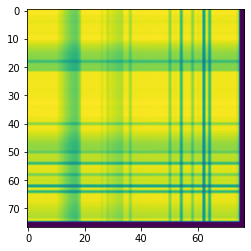

In [3]:
# cosine_similarity
cos_sim=np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
plt.imshow(cos_sim)

# using scipy, it calculates 1-cosine
from scipy.spatial import distance
print(f"The cosine distance using Scipy is : {distance.cosine(A.reshape(1,-1),B.reshape(1,-1))}" )

# using sklearn to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
cos_sim=cosine_similarity(A.reshape(1,-1),B.reshape(1,-1))
print (f"Cosine Similarity between A and B: {cos_sim} ")
print (f"Cosine Distance between A and B: {1-cos_sim} ")



## Similarity SSM

In this section we investigate similarity before constructing the SSM. Therefore, we construct a similarity SSM $S = X \cdot X^T$ where $X$ is a performance $A$ and $X^T$ is a performance $B^T$.

In [5]:
MATCHSCORE_DIR = os.path.dirname(os.path.dirname(os.getcwd())) + "\\alignments\\match_4\\"
ARTIFACT_DIR = os.path.dirname(os.path.dirname(os.getcwd())) + "\\alignments\\ssm\\"
NUMBER_OF_WINDOWS = 6
NUMBER_OF_STATS = 6
SIZE_OF_INTVEC = 6
step = 0.5


def dynamics_analysis(note_array, duration, forward_step_lim, step=1 ):
    '''
    Does the dynamic analysis of a piece.
    
    Parameters:
    -----------
    note_array : array(tuples)
        The note_array from the partitura analysis
    
    duration : float
        The duration of a piece in seconds
    
    step : float
        The step for the analysis window.
    
    Returns:
    --------
    X : array
        An array of size len(duration of analysis) N x 6 x 6. 
    '''
    # normalize duration
    duration = duration/step
    step_unit = 1
    dim = int(round((duration-(NUMBER_OF_WINDOWS*step_unit))/step_unit)+1)
    # Experimenting with array resolution
    X = np.zeros((dim, NUMBER_OF_WINDOWS, NUMBER_OF_STATS))
    index = 0
    for i in range(1 , dim-1, step_unit):
        fix_start = i*step
        for j in range(1, NUMBER_OF_WINDOWS + 1):
            x = list()
            ind_list = list()
            if len(note_array[index:]) > forward_step_lim*j:
                look_in = forward_step_lim*j+index
            else :
                look_in = len(note_array)
            for ind, note in enumerate(note_array[index:look_in]):
                note_start = note[0] #onset
                note_end = note[0] + note[1] #onset + duration
                fix_end = fix_start + (j*step)                
                # check if note is in window
                if  fix_start <= note_start <= fix_end :
                    ind_list.append(ind)
                    x.append(note[5]*note[1]) # Velocity
                elif note_start <= fix_start and note_end >= fix_start:
                    ind_list.append(ind)
                    x.append(note[5]*note[1]) # velocity
            if x != []:
                X[i-1][j-1] = [np.mean(x), np.var(x), np.std(x), min(x), max(x), max(x) - min(x)]
        if ind_list != [] : 
            index += min(ind_list)
    return X

def analyze(file):
    """Create the dynamics analysis of the file.
    
    Parameters
    ----------
    file : string
        The name of the file + extension, i.e. has to be a match score in the predifed directory.
    Returns
    ----------
    X : array
        An array of size len(duration of analysis) N x 6 x 6. 
    
        """
    ppart, alignment, spart = partitura.load_match(MATCHSCORE_DIR + file, create_part=True)
    note_array, _ = to_matched_score(spart, ppart, alignment)
    durations = [n[1] for n in note_array if n[1]!=0]
    min_duration = min(durations)
    max_duration = max(durations)
    max_polyphony = max([len(list(item[1])) for item in itertools.groupby(note_array, key=lambda x: x[0])])
    forward_step_lim = int(max_duration/min_duration + max_polyphony)
    duration = note_array[-1][0]
    note_array = sorted(note_array, key=lambda note: note[0])
    X = dynamics_analysis(note_array, duration, forward_step_lim, step)
    low_rank_part, _ = robust_pca(X, reg_E=0.04, learning_rate=1.2, n_iter_max=20)
    return low_rank_part

def periodic_corr(x, y):
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    return np.fft.ifft(np.fft.fft(x) * np.fft.fft(y).conj()).real

In [6]:
A = analyze("Chopin_op10_no3_p18.match")
B = analyze("Chopin_op10_no3_p12.match")




In [7]:
N = A.shape[0]
pearson_corr = list() 
spearman_corr = list()
cos_sim = np.zeros((N, 6, 6))
for i in range(N):
    cos_sim[i] = np.dot(A[i], B[i])/(np.linalg.norm(A[i])*np.linalg.norm(B[i]))

X = A.reshape(A.shape[0], A.shape[1]*A.shape[2])
Y = B.reshape(B.shape[0], B.shape[1]*B.shape[2])

for i in range(N):
    spearman_corr.append(scipy.stats.spearmanr(X[i], Y[i])[0])
    pearson_corr.append(scipy.stats.pearsonr(X[i], Y[i])[0])
    
pearson_corr = np.array(pearson_corr)[np.newaxis]
spearman_corr = np.array(spearman_corr)[np.newaxis]
circular_corr = periodic_corr(A, B)

<ipython-input-7-6a0e1e83c867>:6: RuntimeWarning: invalid value encountered in true_divide
  cos_sim[i] = np.dot(A[i], B[i])/(np.linalg.norm(A[i])*np.linalg.norm(B[i]))
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\melki\AppData\Local\Programs\Python\Python38\lib\site

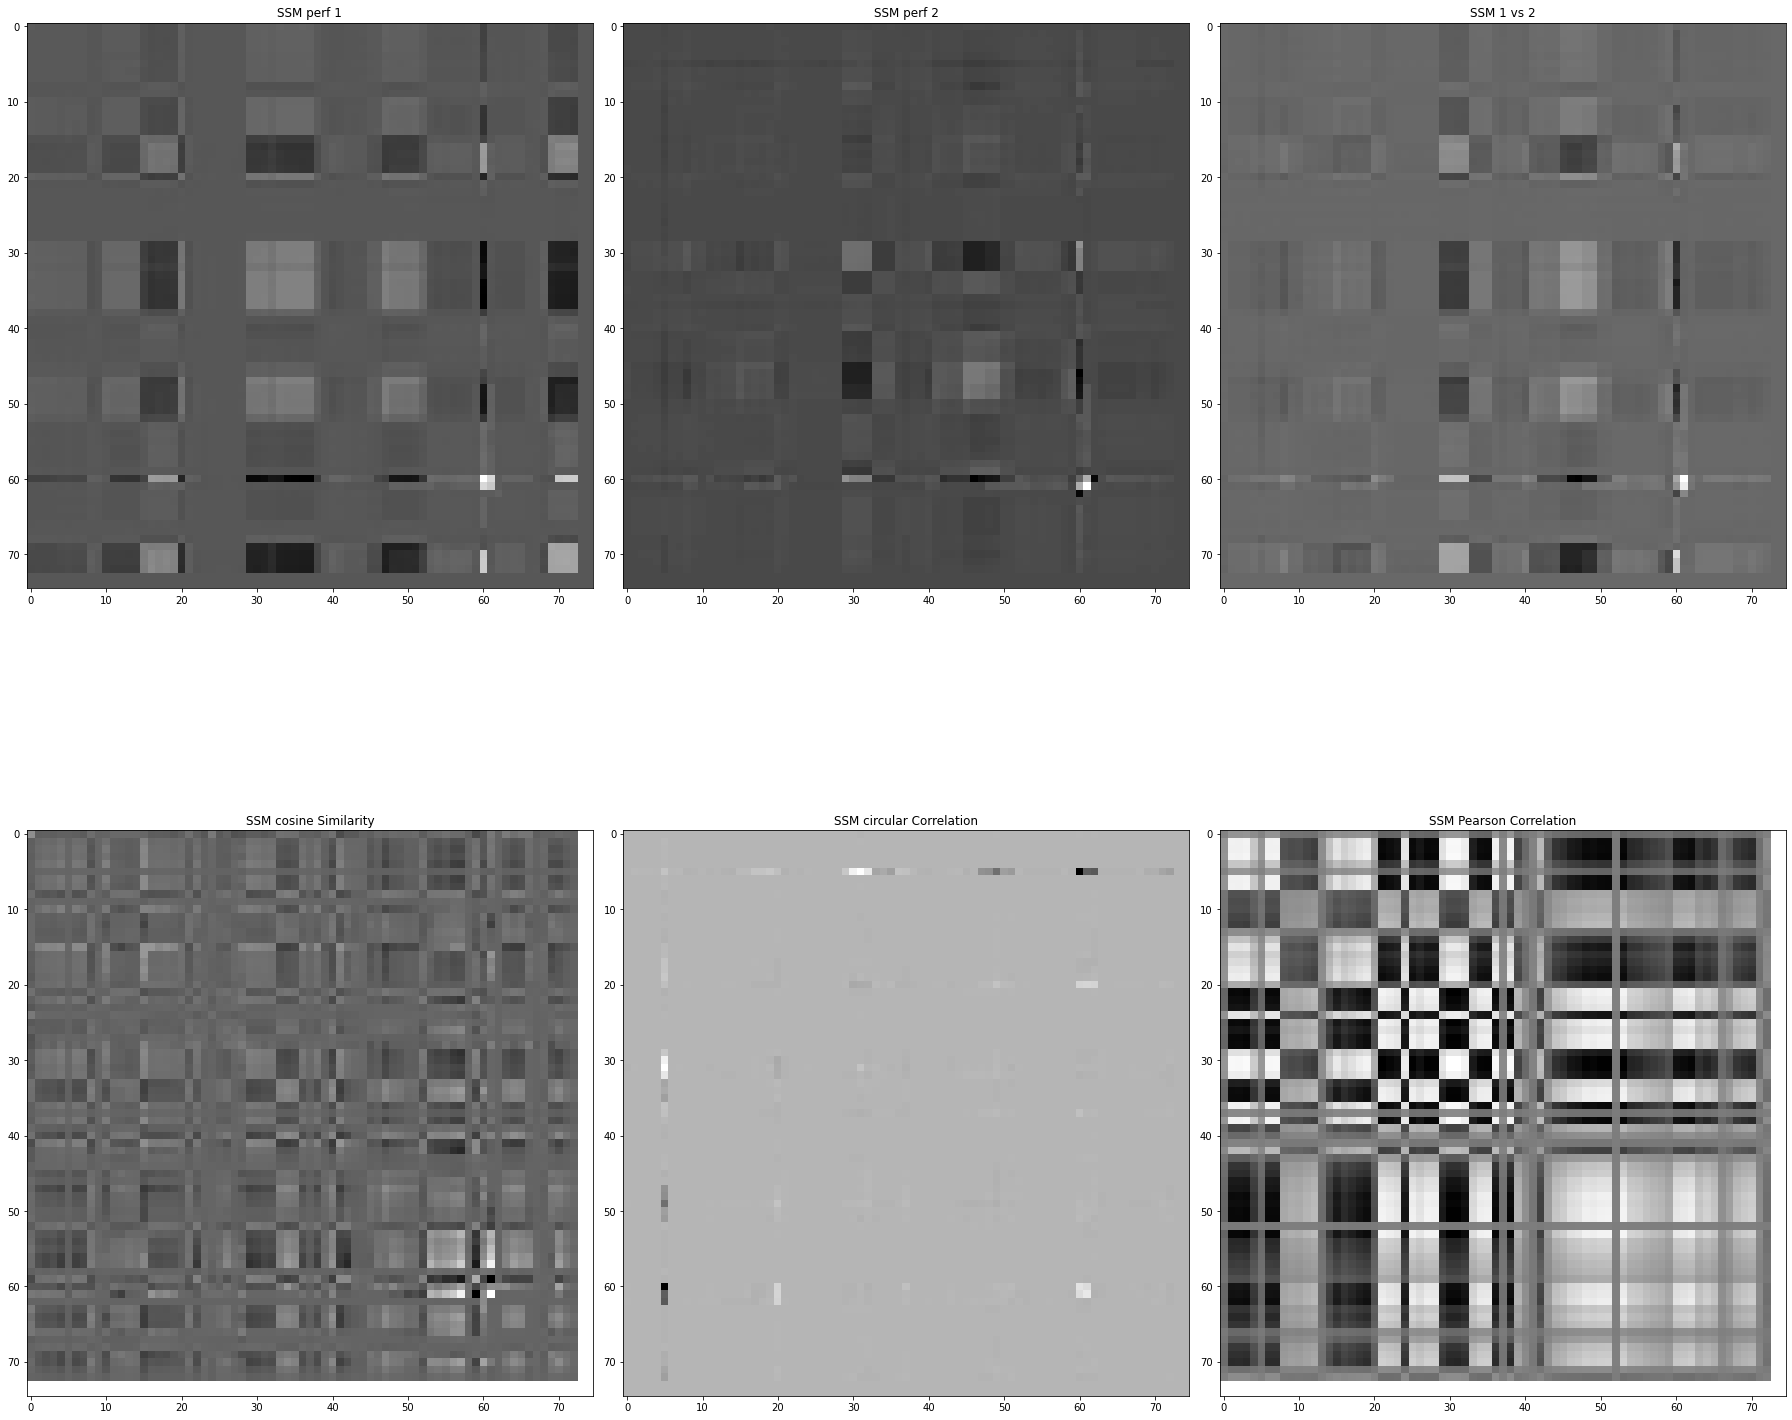

In [8]:
S1 = np.tensordot(A, A.T) 
S2 = np.tensordot(B, B.T)
S = np.tensordot(A, B.T)

cmap = "gray"
f, axarr = plt.subplots(2,3, figsize=(25, 25))
axarr[(0, 0)].imshow(S1, cmap=cmap)
axarr[(0, 0)].title.set_text('SSM perf 1')
axarr[(0, 1)].imshow(S2, cmap=cmap)
axarr[(0, 1)].title.set_text('SSM perf 2')
axarr[(0, 2)].imshow(S, cmap=cmap)
axarr[(0, 2)].title.set_text('SSM 1 vs 2')
axarr[(1, 0)].imshow(np.tensordot(cos_sim, cos_sim.T), cmap=cmap)
axarr[(1, 0)].title.set_text('SSM cosine Similarity')
axarr[(1, 1)].imshow(np.tensordot(circular_corr, circular_corr.T), cmap=cmap)
axarr[(1, 1)].title.set_text('SSM circular Correlation')
axarr[(1, 2)].imshow(pearson_corr.T @ pearson_corr, cmap=cmap)
axarr[(1, 2)].title.set_text('SSM Pearson Correlation')
plt.tight_layout()

# Performance Similarity Measures

In [12]:
import partitura
import numpy as np
from basismixer.performance_codec import PerformanceCodec, get_performance_codec, to_matched_score, tempo_by_average

match_fn = MATCHSCORE_DIR + "Chopin_op10_no3_p18.match"

ppart, alignment, spart = partitura.load_match(match_fn, create_part=True)
note_array, snote_ids_array = to_matched_score(spart, ppart, alignment)
parameter_names = ['beat_period', 'velocity', 'timing', 'articulation_log']
# initialize a performance codec
pc = get_performance_codec(parameter_names)
matched_score, snote_ids = pc.encode(spart, ppart, alignment)
durations = [n[1] for n in note_array if n[1]!=0]
min_duration = min(durations)
max_duration = max(durations)
max_polyphony = max([len(list(item[1])) for item in itertools.groupby(note_array, key=lambda x: x[0])])
print(matched_score.dtype)

[('beat_period', '<f4'), ('timing', '<f4'), ('articulation_log', '<f4'), ('velocity', '<f4')]


In [13]:
def standard_analysis(func, note_array, duration, forward_step_lim, step, NUMBER_OF_WINDOWS, NUMBER_OF_STATS):
    '''
    A generalized definition for match score analysis
    
    Parameters:
    -----------
    note_array : array(tuples)
        The note_array from the partitura analysis
    
    duration : float
        The duration of a piece in seconds
    
    step : float
        The step for the analysis window.
    
    Returns:
    --------
    X : array
        An array of size len(duration of analysis) N x 6 x 6. 
    '''
    # normalize duration
    duration = duration/step
    step_unit = 1
    dim = int(round((duration-(NUMBER_OF_WINDOWS*step_unit))/step_unit)+1)
    # Experimenting with array resolution
    X = np.zeros((dim, NUMBER_OF_WINDOWS, NUMBER_OF_STATS))
    index = 0
    for i in range(1 , dim-1, step_unit):
        fix_start = i*step
        for j in range(1, NUMBER_OF_WINDOWS + 1):
            x = list()
            ind_list = list()
            if len(note_array[index:]) > forward_step_lim*j:
                look_in = forward_step_lim*j+index
            else :
                look_in = len(note_array)
            for ind, note in enumerate(note_array[index:look_in]):
                note_start = note[0] #onset
                note_end = note[0] + note[1] #onset + duration
                fix_end = fix_start + (j*step)                
                # check if note is in window
                if  fix_start <= note_start <= fix_end :
                    ind_list.append(ind)
                    x.append(note) # Expressive Parameters
                elif note_start <= fix_start and note_end >= fix_start:
                    ind_list.append(ind)
                    x.append(note) # Expressive Parameters
            if x != []:
                X[i-1][j-1] = func(x) 
        if ind_list != [] : 
            index += min(ind_list)
    return X

def tempo_of_segment(x):
    """
    Tempo feature extraction per windows.
    
    Parameters:
    -----------
    x : list(tuples)
        A segment of the note_array
    
    Returns:
    --------
    np.mean(y[0]) : float
        The mean of the tempo curve for the segment x.
    
    """   
    
    score_onsets, score_durations, _, performed_onsets, performed_durations, _ = list(zip(*x))   
    print(score_onsets)
    y = tempo_by_average(score_onsets, performed_onsets, score_durations, performed_durations)
    return np.mean(y[0])


In [14]:
tempo_analysis = standard_analysis(lambda x : tempo_of_segment(x),
                                   note_array, note_array[-1][0], int(max_duration/min_duration + max_polyphony), 0.5)
tempo_analysis = tempo_analysis.reshape(tempo_analysis.shape[0], tempo_analysis.shape[1]*tempo_analysis.shape[2])

TypeError: standard_analysis() missing 2 required positional arguments: 'NUMBER_OF_WINDOWS' and 'NUMBER_OF_STATS'

In [ ]:
print(tempo_analysis.shape, note_array.shape)


S = tempo_analysis @ tempo_analysis.T

plt.imshow(S)

## Entropy

In [19]:
import scipy as sc

def von_neumann_entropy(rho):
    R = rho*(sc.linalg.logm(rho)/sc.linalg.logm(np.matrix([[2]])))
    S = -np.matrix.trace(R)
    return(S)

def vn_eig_entropy(rho):
    EV = sc.linalg.eigvals(rho)

    # Drop zero eigenvalues so that log2 is defined
    my_list = [x for x in EV.tolist() if x]
    EV = np.array(my_list)

    log2_EV = np.matrix(np.log2(EV))
    EV = np.matrix(EV)
    S = -np.dot(EV, log2_EV.H)
    return(S)

In [21]:
print(vn_eig_entropy(A))

[[-1889254.74572011-66.8694526j]]
